In [23]:
### Quantification frequency analysis ###
# wt and r - No IgM

# Import required packages
library(alakazam)
library(shazam)
library(dplyr)
library(ggplot2)

require(data.table)
db <- as.data.frame(fread("wt_r.tsv"))

In [24]:
# Collapse clonal groups into single sequences
clones <- collapseClones(db, cloneColumn="clone_id", 
                         sequenceColumn="sequence_alignment", 
                         germlineColumn="germline_alignment_d_mask", 
                         regionDefinition=IMGT_V, 
                         method="thresholdedFreq", minimumFrequency=0.6,
                         includeAmbiguous=FALSE, breakTiesStochastic=FALSE, 
                         nproc=1)

In [25]:
# Count observed mutations and append mu_count columns to the output
observed <- observedMutations(clones, 
                              sequenceColumn="clonal_sequence",
                              germlineColumn="clonal_germline",
                              regionDefinition=IMGT_V, nproc=1)

# Count expected mutations and append mu_exptected columns to the output
expected <- expectedMutations(observed, 
                              sequenceColumn="clonal_sequence",
                              germlineColumn="clonal_germline",
                              targetingModel=HH_S5F,
                              regionDefinition=IMGT_V, nproc=1)

In [26]:
# Calculate selection scores using the output from expectedMutations
baseline_expected <- calcBaseline(expected, testStatistic="focused", 
                         regionDefinition=IMGT_V, nproc=1)

calcBaseline will use existing observed and expected mutations, in the fields: mu_count_cdr_r, mu_count_cdr_s, mu_count_fwr_r, mu_count_fwr_s and mu_expected_cdr_r, mu_expected_cdr_s, mu_expected_fwr_r, mu_expected_fwr_s



Calculating BASELINe probability density functions...


In [27]:
# Calculate selection scores from scratch
baseline_clones <- calcBaseline(clones, testStatistic="focused", 
                         regionDefinition=IMGT_V, nproc=1)

calcBaseline will calculate observed and expected mutations for clonal_sequence using clonal_germline as a reference.



Calculating BASELINe probability density functions...


In [28]:
# Combine selection scores by time-point
grouped_1 <- groupBaseline(baseline_clones, groupBy="sample_id")

Grouping BASELINe probability density functions...
Calculating BASELINe statistics...


In [29]:
# Subset the original data to switched isotypes
db_sub <- subset(db, c_call %in% c("IGHM", "IGHG", "IGHD", "IGHA"))

# Collapse clonal groups into single sequence
clones_sub <- collapseClones(db_sub, cloneColumn="clone_id",
                             sequenceColumn="sequence_alignment",
                             germlineColumn="germline_alignment_d_mask",
                             regionDefinition=IMGT_V, 
                             method="thresholdedFreq", minimumFrequency=0.6,
                             includeAmbiguous=FALSE, breakTiesStochastic=FALSE, 
                             nproc=1)

# Calculate selection scores from scratch
baseline_sub <- calcBaseline(clones_sub, testStatistic="focused", 
                             regionDefinition=IMGT_V, nproc=1)

# Combine selection scores by time-point and isotype
grouped_2 <- groupBaseline(baseline_sub, groupBy=c("sample_id", "c_call"))

calcBaseline will calculate observed and expected mutations for clonal_sequence using clonal_germline as a reference.



Calculating BASELINe probability density functions...
Grouping BASELINe probability density functions...
Calculating BASELINe statistics...


In [30]:
# First group by subject and status
subject_grouped <- groupBaseline(baseline_sub, groupBy=c("status", "subject"))

# Then group the output by status
status_grouped <- groupBaseline(subject_grouped, groupBy="status")

ERROR: Error in `[.data.frame`(baseline@db, , groupBy): undefined columns selected


In [31]:
testBaseline(grouped_1, groupBy="sample_id")

region,test,pvalue,fdr
<chr>,<chr>,<dbl>,<dbl>
cdr,r != wt,0.04267448,0.04267448
fwr,r != wt,0.02037351,0.04074701


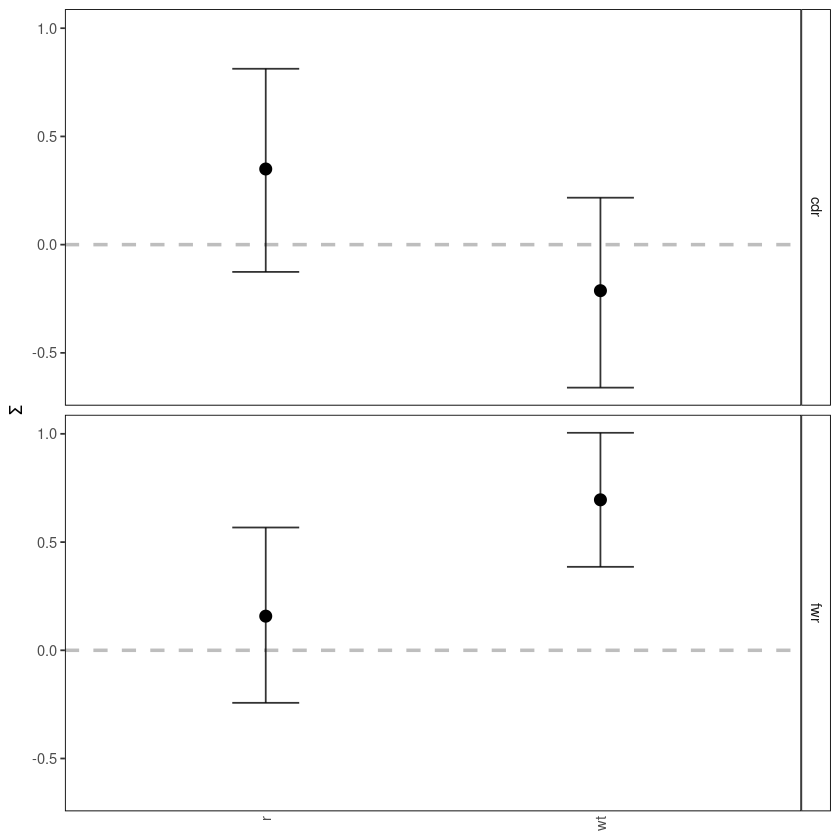

In [32]:
# Set sample and isotype colors
sample_colors <- c("r"="deeppink1", "wt"="black")
isotype_colors <- c("IGHM"="darkorchid", "IGHD"="firebrick", 
                    "IGHG"="seagreen", "IGHA"="steelblue")

# Plot mean and confidence interval by time-point
plotBaselineSummary(grouped_1, "sample_id")

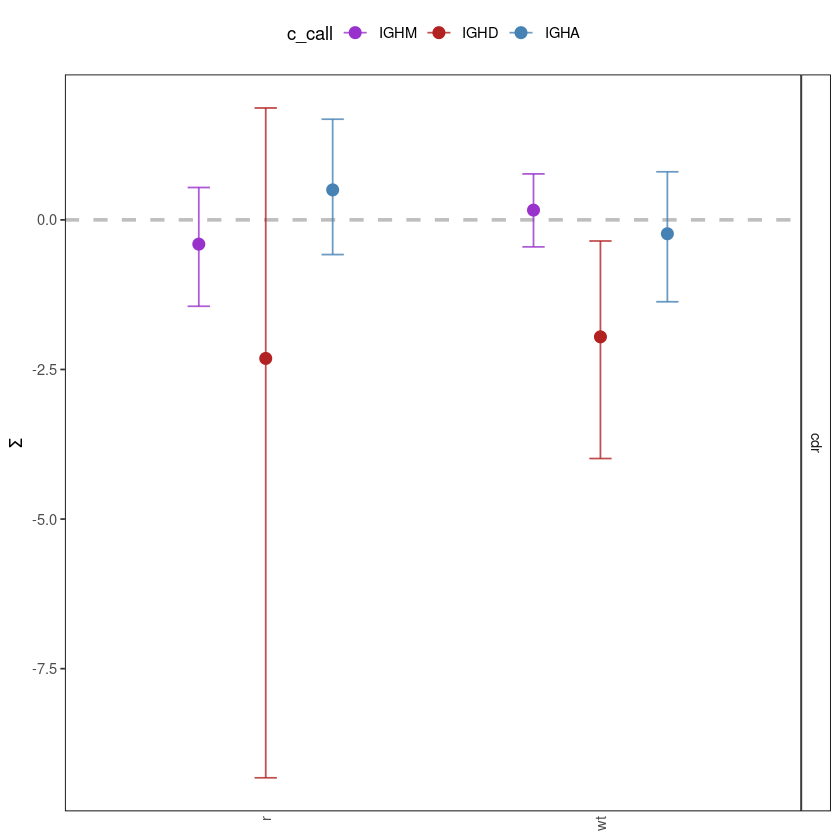

In [33]:
# Plot selection scores by time-point and isotype for only CDR
plotBaselineSummary(grouped_2, "sample_id", "c_call", groupColors=isotype_colors,
                    subsetRegions="cdr")

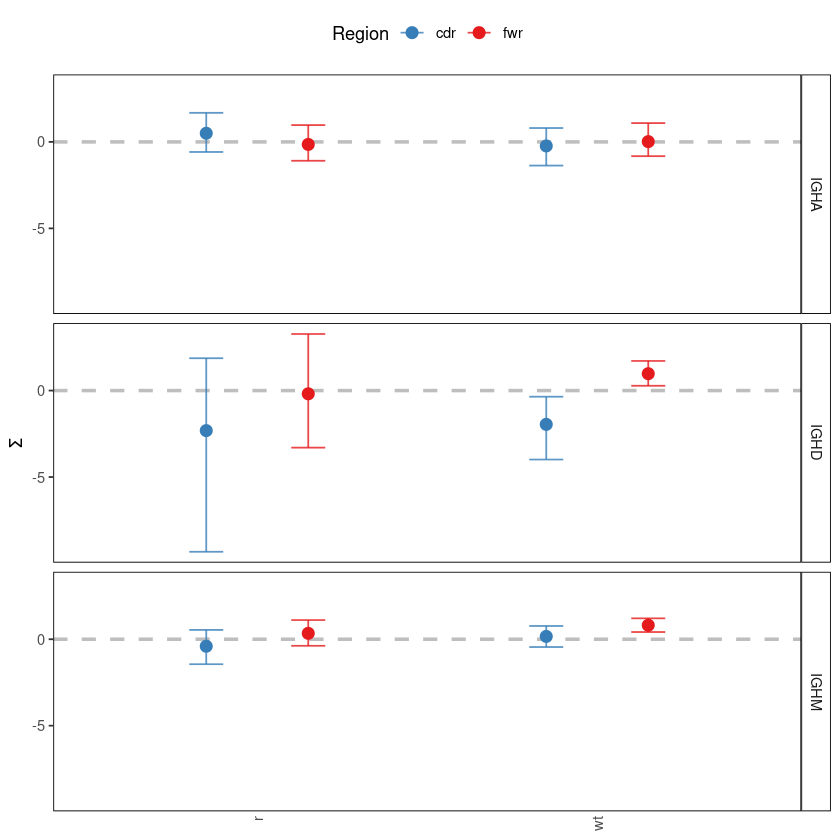

In [34]:
# Group by CDR/FWR and facet by isotype
plotBaselineSummary(grouped_2, "sample_id", "c_call", facetBy="group")

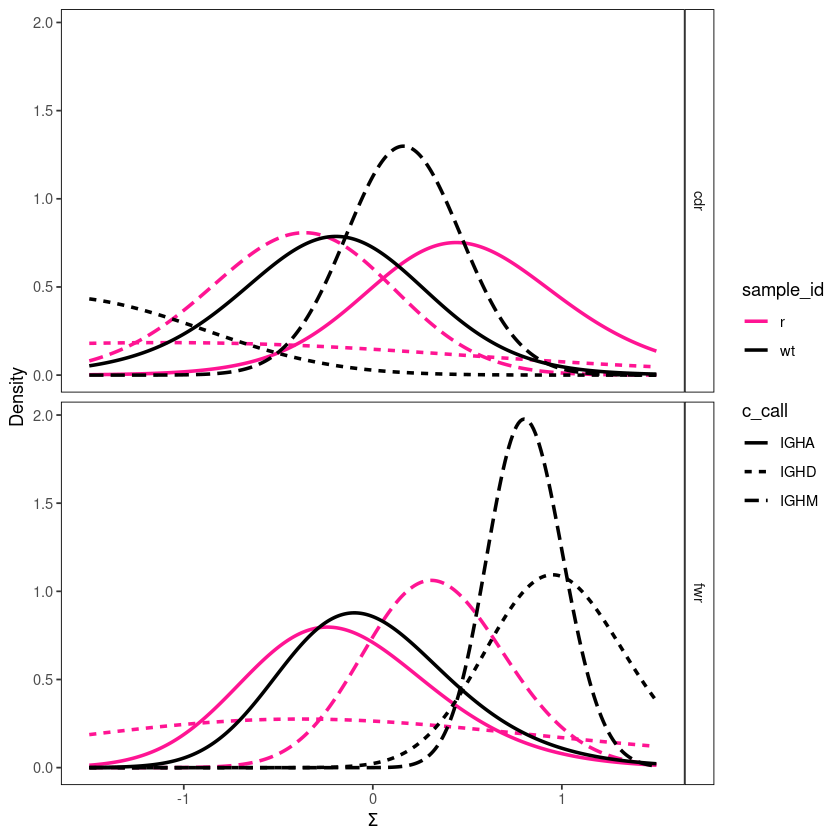

In [35]:
# Plot selection PDFs for a subset of the data
plotBaselineDensity(grouped_2, "c_call", groupColumn="sample_id", colorElement="group", 
                    colorValues=sample_colors, sigmaLimits=c(-1.5, 1.5))